<a href="https://colab.research.google.com/github/dangcait/cdang_225a/blob/main/code/Dang_bms225a_ds_workshop_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [82]:
# install scanpy with additional dependences
# leiden for clustering, harmony for batch correction and skmisc which is needed for HVG selection
!pip install --quiet 'scanpy[leiden,harmony,skmisc]'

The following cell downloads the original data and creates the data files `/content/blood_RNA_raw_counts.h5ad` and `/content/blood_RNA_raw_counts_SCG12.h5ad` that we will use for our analysis.

In [83]:
# @title Download Data and create the **raw data** files that we will use for our analysis
################# THIS IS NOT PART OF THE WORKFLOW ##################
import os

if not os.path.exists('/content/blood_RNA.h5ad'):
  # downloading the data from the paper takes ~1min
  !wget https://figshare.com/ndownloader/files/38849385?private_link=8aaa376913da23ae0def -O blood_RNA.h5ad > /dev/null 2>&1


if not os.path.exists('/content/blood_RNA_raw_counts.h5ad'):
  # -- create the raw data by removing all processed data information from the author's file
  import scanpy as sc
  # load the single cell RNA seq dataset from the h5ad file
  adata_processed = sc.read_h5ad('blood_RNA.h5ad') # AnnData object
  X_raw_counts = adata_processed.layers['counts']
  # the var dataframe
  raw_var_df = adata_processed.raw.var.copy()
  for i in raw_var_df.columns:
    del raw_var_df[i]
  raw_var_df['gene_name'] = raw_var_df.index
  # the obs dataframe
  raw_obs_df = adata_processed.obs[['LIBRARY',	'CoLabs_patient',	'condition']]
  raw_obs_df.columns = ['LIBRARY_ID', 'patient_id', 'condition']
  # create the anndata object
  adata = sc.AnnData(X = X_raw_counts, var=raw_var_df, obs=raw_obs_df)
  adata.write_h5ad('blood_RNA_raw_counts.h5ad')
  adata=adata[ adata.obs['LIBRARY_ID'] == 'XAUT1-POOL-SCG12']
  adata.write_h5ad('blood_RNA_raw_counts_SCG12.h5ad')
  del adata, adata_processed # delete the all data

# Single cell RNA seq analysis (single batch)
## Let's do a single batch first
The `'blood_RNA_raw_counts_SCG12.h5ad'` file only contains the single-cell data from a single sequencing batch (library):

LIBRARY_ID: `XAUT1-POOL-SCG12`.

In [84]:
import pandas as pd
import scanpy as sc

In [85]:
### Settings ###

# (optional) Show more columns in output
pd.set_option('display.max_columns', 50)

# (optional) Set parameters for the figures // sc.settings.set_figure_params?
sc.settings.set_figure_params(dpi=80,fontsize=16, facecolor="white",figsize=(8,6),color_map='viridis')

# (optional) Suppress all warnings -- not recommended when working on your research projects!
import warnings
warnings.filterwarnings("ignore")

# print out the package versions
print('scanpy version:', sc.__version__)

scanpy version: 1.10.3


## STEP 0: Load the data (raw counts)

In [86]:
###################################################### <- this will mark the functions that will change/update adata
adata = sc.read_h5ad('blood_RNA_raw_counts_SCG12.h5ad') # load the AnnData object from the h5ad file

In [87]:
adata

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition'
    var: 'gene_name'

In [ ]:
# [🔺] lets explore what is in adata
# adata.obs, adata.X, adata.var, adata.var_names

## STEP 1: Quality control

In [88]:
######################################################
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [89]:
adata.var.head()

,gene_name,mt
RP11-34P13.7,RP11-34P13.7,False
RP11-34P13.15,RP11-34P13.15,False
RP11-34P13.16,RP11-34P13.16,False
RP11-34P13.13,RP11-34P13.13,False
FO538757.2,FO538757.2,False


In [90]:
# [🔺] pandas practice: select the var rows that correspond to mitochondrial genes
# Hint: slice adata.var where the 'mt' column of adata.var is equal to True

adata.var[adata.var['mt']]

,gene_name,mt
MT-RNR1,MT-RNR1,True
MT-TV,MT-TV,True
MT-RNR2,MT-RNR2,True
MT-TL1,MT-TL1,True
MT-ND1,MT-ND1,True
MT-TM,MT-TM,True
MT-ND2,MT-ND2,True
MT-TA,MT-TA,True
MT-TC,MT-TC,True
MT-CO1,MT-CO1,True


In [ ]:
# [🔹] for practice you can also add a column that indicates whether a gene is ribosomal
# ribosomal genes start with "RP" for human, "Rp" for mouse

### Calculate QC metrics

In [91]:
adata # lets remind ourseleves about adata, the following command will add a lot of information

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition'
    var: 'gene_name', 'mt'

In [92]:
######################################################
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

In [93]:
adata

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Filter genes

In [94]:
######################################################
sc.pp.filter_genes(adata,min_cells=5) #filter genes that are expressed in fewer than 5 cells

In [95]:
adata # notice that the number of genes decreased

AnnData object with n_obs × n_vars = 6410 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Visualize QC metrics (cells)

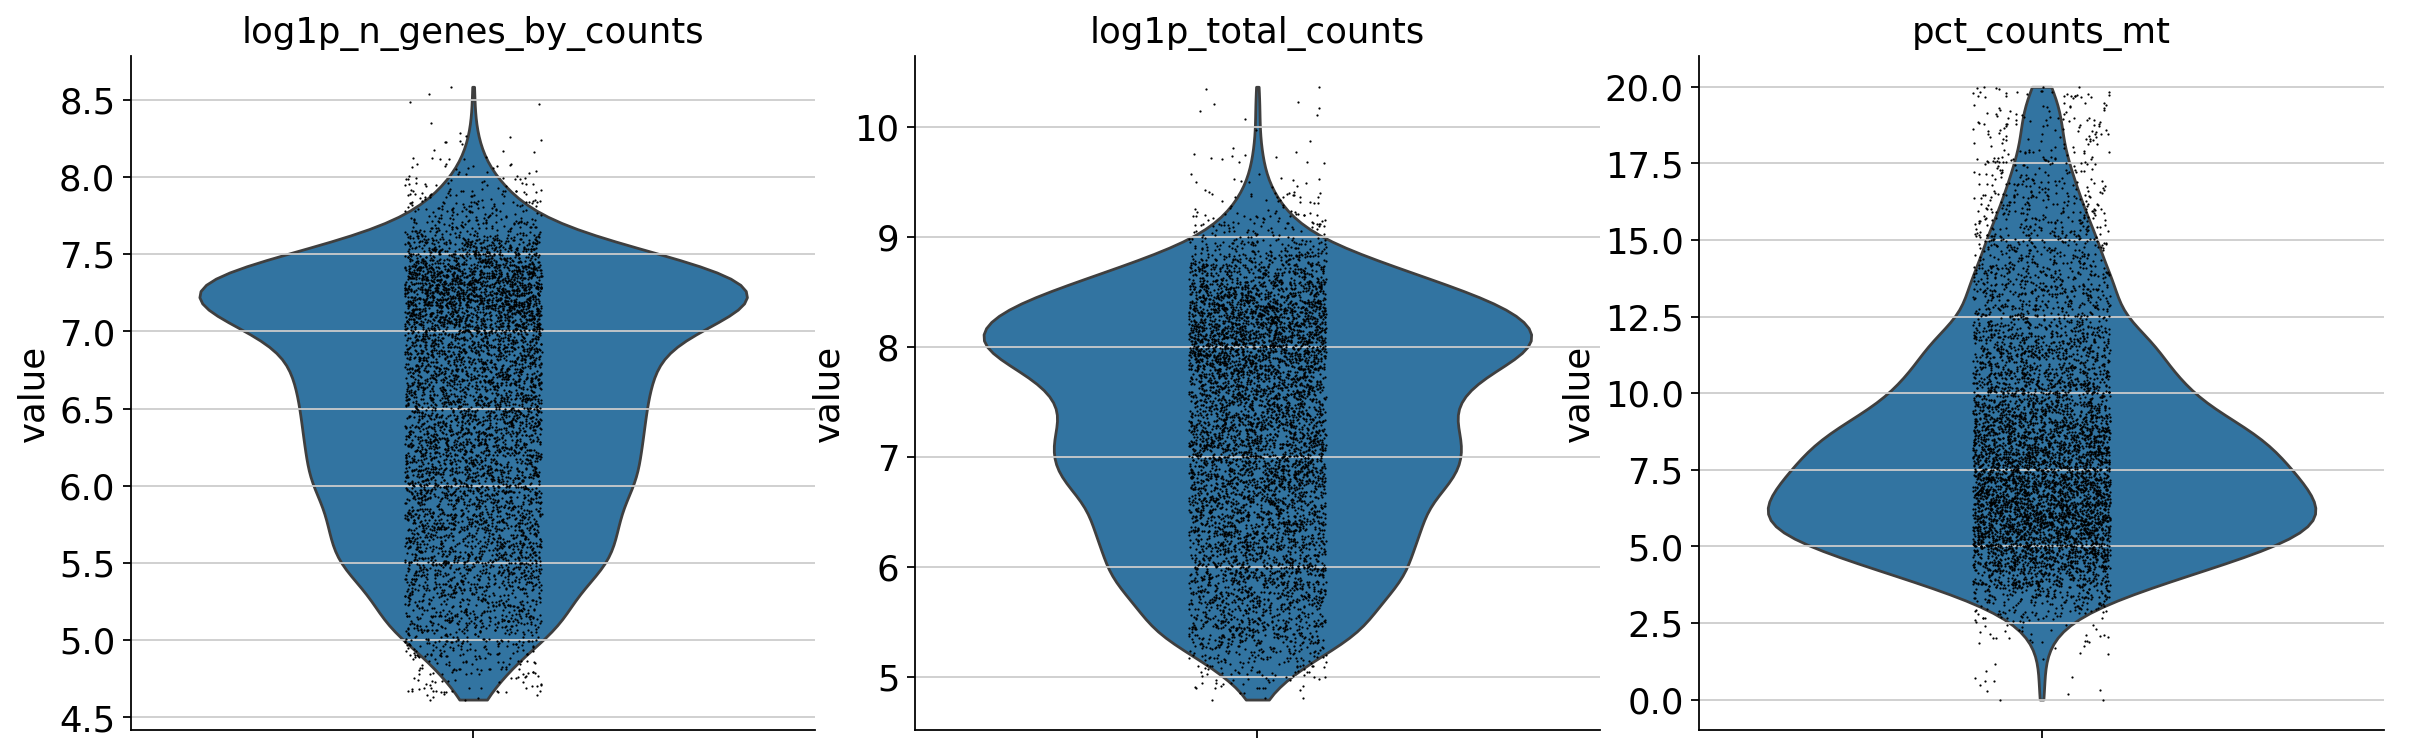

In [96]:
sc.pl.violin(
    adata,
    keys = ["log1p_n_genes_by_counts", "log1p_total_counts", "pct_counts_mt"],
    jitter=0.1,
    multi_panel=True,
    size=1
)

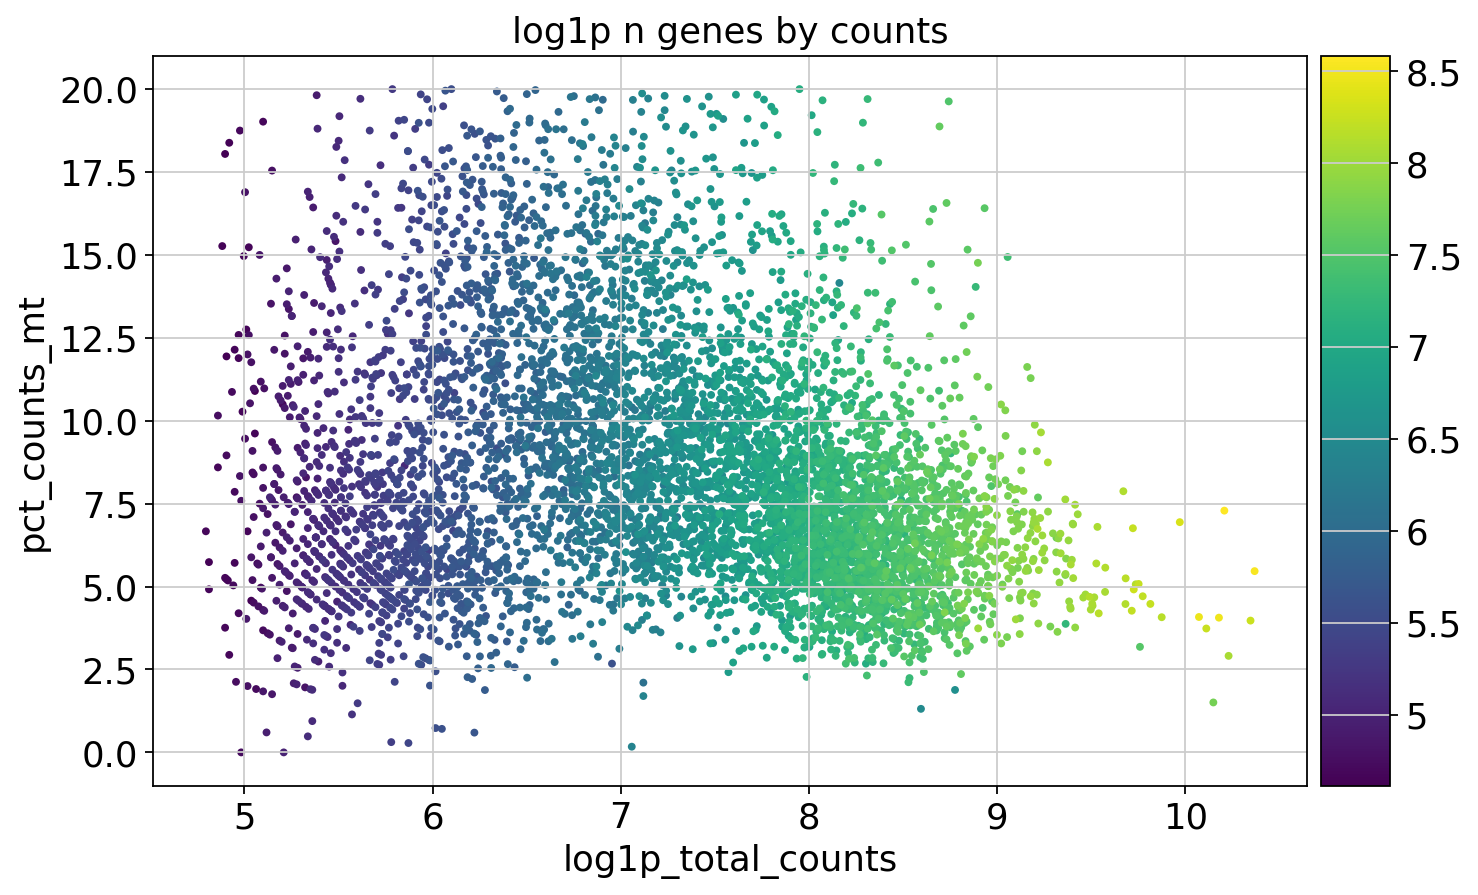

In [97]:
sc.pl.scatter(adata, "log1p_total_counts", "pct_counts_mt", color="log1p_n_genes_by_counts",size=50)

### Filter cells

In [101]:
# [🔺] pandas practice: How many cells have log1p_total_counts above 8?

adata.obs[adata.obs['log1p_total_counts']>8]

,LIBRARY_ID,patient_id,condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCTGAGTCAATAG-1_2,XAUT1-POOL-SCG12,XAUT1-HS2,HC,1317,7.183871,3584.0,8.184514,40.541295,53.069196,63.616071,77.204241,316.0,5.758902,8.816964
AAACCTGCATTAACCG-1_2,XAUT1-POOL-SCG12,XAUT1-HS3,HC,1244,7.126891,2982.0,8.000685,35.881958,46.948357,58.819584,75.050302,191.0,5.257495,6.405097
AAACCTGTCAGCACAT-1_2,XAUT1-POOL-SCG12,XAUT1-HS4,HC,1478,7.299121,5301.0,8.575839,47.198642,61.139408,70.514997,81.550651,218.0,5.389072,4.112432
AAACGGGGTCGCCATG-1_2,XAUT1-POOL-SCG12,XAUT1-HS4,HC,1298,7.169350,4570.0,8.427487,46.542670,61.684902,71.553611,82.538293,287.0,5.662960,6.280088
AAACGGGGTTAAAGTG-1_2,XAUT1-POOL-SCG12,XAUT1-HS2,HC,1557,7.351158,3972.0,8.287277,34.692850,46.878147,58.131923,73.388721,410.0,6.018593,10.322256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGCGACAT-1_2,XAUT1-POOL-SCG12,XAUT1-HS10,UCV,1418,7.257708,3680.0,8.210940,39.538043,51.358696,61.467391,75.054348,262.0,5.572154,7.119565
TTTGGTTGTCAGAGGT-1_2,XAUT1-POOL-SCG12,XAUT1-HS8,UCNB,1703,7.440734,4932.0,8.503703,36.354420,48.580697,60.442011,74.939173,359.0,5.886104,7.278994
TTTGGTTTCACAGTAC-1_2,XAUT1-POOL-SCG12,XAUT1-HS10,UCV,1941,7.571474,4431.0,8.396606,29.383886,38.636877,48.747461,64.928910,380.0,5.942799,8.575942
TTTGTCACACATCCAA-1_2,XAUT1-POOL-SCG12,XAUT1-HS3,HC,1902,7.551187,6315.0,8.750841,40.411718,55.502771,65.558195,76.769596,349.0,5.857933,5.526524


In [102]:
##################################################
# filter out cells by choosing QC thresholds
# e.g., based on the above plots, ok to be lenient we can revisit this after clustering

adata = adata[adata.obs['log1p_total_counts']> 6.5]
adata = adata[adata.obs['pct_counts_mt']< 15 ]

In [103]:
adata # notice that the number of cells decreased

View of AnnData object with n_obs × n_vars = 4453 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Doublet detection (scrublet)

- We expect very few doublets in this particular case. The majority of doublets were removed using genetic information / patient SNPs.


In [104]:
#############################################
# doublet detection with scrublet
sc.pp.scrublet(adata)

In [105]:
adata # notice the columns 'doublet_score' and 'predicted_doublet' were added in obs. Also .uns appeared.

AnnData object with n_obs × n_vars = 4453 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

In [106]:
# .value_counts(): count how many times a value appears in a column of a dataframe
adata.obs.value_counts('predicted_doublet')

,count
predicted_doublet,
False,4451
True,2


In [108]:
##############################################
# [🔺] AnnData challenge: filter out detected doublets!
# Hint1: adata can be sliced as a DataFrame, i.e., adata[ some condition here ]
# Hint2: adata.obs has the predicted_doublet column which is False for the cells we want to keep

condition = adata.obs['predicted_doublet']==False
adata.obs[condition]




,LIBRARY_ID,patient_id,condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,doublet_score,predicted_doublet
AAACCTGAGTCAATAG-1_2,XAUT1-POOL-SCG12,XAUT1-HS2,HC,1317,7.183871,3584.0,8.184514,40.541295,53.069196,63.616071,77.204241,316.0,5.758902,8.816964,0.067273,False
AAACCTGCAATGGAGC-1_2,XAUT1-POOL-SCG12,XAUT1-HS4,HC,382,5.948035,728.0,6.591674,46.016484,60.989011,75.000000,100.000000,108.0,4.691348,14.835165,0.041805,False
AAACCTGCAGTAAGAT-1_2,XAUT1-POOL-SCG12,XAUT1-HS4,HC,702,6.555357,1732.0,7.457609,43.013857,58.198614,71.016166,88.337182,116.0,4.762174,6.697460,0.035650,False
AAACCTGCATTAACCG-1_2,XAUT1-POOL-SCG12,XAUT1-HS3,HC,1244,7.126891,2982.0,8.000685,35.881958,46.948357,58.819584,75.050302,191.0,5.257495,6.405097,0.040155,False
AAACCTGGTGAGTGAC-1_2,XAUT1-POOL-SCG12,XAUT1-HS2,HC,1188,7.080868,2938.0,7.985825,39.823009,52.144316,62.593601,76.582709,401.0,5.996452,13.648741,0.077856,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAGAGTGTG-1_2,XAUT1-POOL-SCG12,XAUT1-HS7,UCNB,474,6.163315,743.0,6.612041,36.069987,49.528937,63.122476,100.000000,73.0,4.304065,9.825034,0.041805,False
TTTGTCAGTCGGATCC-1_2,XAUT1-POOL-SCG12,XAUT1-HS7,UCNB,910,6.814543,1783.0,7.486613,32.922042,45.372967,58.272574,77.005048,116.0,4.762174,6.505889,0.035650,False
TTTGTCAGTTGTACAC-1_2,XAUT1-POOL-SCG12,XAUT1-HS3,HC,1257,7.137278,3364.0,8.121183,42.390012,54.875149,64.833532,77.497027,195.0,5.278115,5.796671,0.035650,False
TTTGTCATCCACGTGG-1_2,XAUT1-POOL-SCG12,XAUT1-HS6,UCNB,491,6.198479,945.0,6.852243,42.433862,55.555556,69.206349,100.000000,95.0,4.564348,10.052910,0.086339,False


## STEP 2: Normalization and log-transformation

In [109]:
##############################################
# Before normalization, we want to save the count data to a new layer
adata.layers["counts"] = adata.X.copy()

In [110]:
adata

AnnData object with n_obs × n_vars = 4453 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'
    layers: 'counts'

In [111]:
##############################################
# Normalizing to 10K total counts
sc.pp.normalize_total(adata,target_sum=10000) # CP10k normalization

- `target_sum = 10000` is kind of arbitrary but very widely used. If we don't specify the target_sum parameter, `sc.pp.normalize_total(adata)` by default will normalize to the median of the total counts.


In [112]:
# The only thing that changed is the X matrix (gene expression),
# which is now normalized to sum to 10K
adata.X.sum(1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

In [113]:
##############################################
# Logarithmize the data
sc.pp.log1p(adata)

In [114]:
adata.X.sum(1) # the X matrix changed. Each entry is now log(1+x)

matrix([[2206.50442962],
        [1146.63708348],
        [1608.12643059],
        ...,
        [2139.56974705],
        [1353.63176362],
        [1412.3376114 ]])

In [ ]:
######################################################
# [🔺] save the log1p normalized counts to a new layer! Let's call it 'log1p'
# We want to keep these around (useful for plotting and differential expression analysis)







## STEP 3: Highly variable genes (feature selection)

In [ ]:
######################################################
sc.pp.highly_variable_genes(adata, n_top_genes = 2000,
                            flavor='seurat_v3',
                            layer='counts')

In [ ]:
# This added information in the var dataframe
adata.var

In [ ]:
# .sort_values(): sort a dataframe with respect to the values of a given column
# .head(10) prints the top 10
adata.var.sort_values('highly_variable_rank').head(10)

## STEP 4: Dimensionality reduction with PCA

In [ ]:
adata # lets remind ourseleves about adata, the PCA will add a more information

In [ ]:
#####################################################################
# Before PCA we typically scale features to unit variance (common step but not absolutely necessary)
# Note that this changes adata.X
sc.pp.scale(adata, zero_center=False) # we don't want to zero center.

In [ ]:
#####################################################################
# PCA: by default this function uses only the highly variable genes
sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

In [ ]:
# notice that the .obsm appeared that holds representations of the cells (embeddings)
adata

In [ ]:
# X_pca is a matrix of reduced dimensions (n_comps=50 in our case).
adata.obsm['X_pca'].shape

### Visualize PCA

In [ ]:
sc.pl.pca(adata,size=50)

In [ ]:
sc.pl.pca(adata,color='patient_id',size=10)

In [ ]:
sc.pl.pca(adata,color=['CST3','CD79A'],size=50,layer='log1p')

## STEP 5: Nearest-neighbor graph, Clustering and UMAP projection

In [ ]:
##############################################################
# construct a k nearest neighbors graph (knn)
# 1. choose which representation to use (default is 'X_pca')
# 2. choose n_neighbors (default is 15). Also can specify random_state for reproducibility.

sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15, random_state=42)

In [ ]:
adata

In [ ]:
##############################################################
# community detection algorithm that is used to cluster cells
# based on the neighbors graph we computed above.

sc.tl.leiden(adata, resolution=1, key_added='leiden') # default parameters

In [ ]:
adata

In [ ]:
##############################################################
# run umap on the neighbors graph we computed above
sc.tl.umap(adata, min_dist=0.5, spread=1.0) # default values for the two main parameters

In [ ]:
adata

### Visualize UMAP

In [ ]:
sc.pl.umap(adata,color=['CST3','CD79A'],size=50,layer='log1p')

In [ ]:
sc.pl.umap(adata,color='leiden',size=50,legend_loc='on data')

In [ ]:
##############################################################
# [🔺] Cluster the cells at a lower resolution, and visualize again
# Give a different name to the labels so that we don't overwrite the 'leiden' column in obs
# Hint: run the sc.tl.leiden and sc.pl.umap functions





In [ ]:
# [🔹] Experiment with different neighbors, leiden and umap parameters

# lets work on a copy of the AnnData object for this
bdata = adata.copy() # anything we do with bdata won't affect adata

### pp.neighbors, tl.leiden, tl.umap and plot with pl.umap






## Extra: Differential expression analysis

In [ ]:
##############################################################
sc.tl.rank_genes_groups(adata,
                        groupby='leiden_coarse',
                        method='wilcoxon',
                        layer='log1p')

In [ ]:
##############################################################
sc.pl.rank_genes_groups_dotplot(adata,
                                n_genes=6,
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=3,
                                vmax=5,
                                vmin=-5,
                                cmap='bwr',
                                dot_max=0.7)


In [ ]:
##############################################################
# [🔺] annotate the clusters!!

clusters_to_labels = {
    '0':'?',
    '1':'??',
    '2':'???',
    '3':'????'

}

# use the above dict to create a new column in obs with all cells labeled
# this is done by first mapping leiden_coarse column to the values of the dict
# and assigning the result to a new column in obs
adata.obs['???'] = adata.obs['leiden_coarse'].map(clusters_to_labels)


## umap plot with the new labels
sc.pl.umap(adata,color='???',size=50,legend_loc='on data',legend_fontoutline=2,legend_fontsize=50)

## STEP 6: Save the processed dataset

In [ ]:
adata.write_h5ad('blood_RNA_BMS225a_single_batch.h5ad') # this will be deleted when this session ends

In [ ]:
### Too big to download so let's mount google drive from the Files tab and save it there
# adata.write_h5ad('/content/drive/MyDrive/your_project_folder/blood_RNA_BMS225a_single_batch.h5ad')

# DONE

#  --> Compact version of the code

In [ ]:
adata = sc.read_h5ad('blood_RNA_raw_counts_SCG12.h5ad') # load the AnnData object from the h5ad file
display(adata)

# QC and doublet detection
adata.var["mt"] = adata.var_names.str.startswith("MT-") # mitochondrial genes, "MT-" for human, "Mt-" for mouse
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True, percent_top = None) # calculate QC metrics
sc.pp.filter_genes(adata,min_cells=5) #filter genes
adata = adata[ adata.obs['log1p_total_counts']> 6.5 ] # filter cells based on counts
adata = adata[ adata.obs['pct_counts_mt']< 12.5 ] # filter cells based on mito percentage
sc.pp.scrublet(adata) # doublet detection with scrublet
adata = adata[ adata.obs['predicted_doublet'] == False ] # filter out detected doublets

# normalization and log-transformation
adata.layers["counts"] = adata.X.copy() # saving count data to a new layer, before we proceed with normalization
sc.pp.normalize_total(adata,target_sum=10000) # Normalizing to 10K total counts (CP10k)
sc.pp.log1p(adata) # Logarithmize the data
adata.layers['log1p'] = adata.X.copy() # save the log1p normalized counts to a new layer

# highly variable gene selection
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor='seurat_v3', layer='counts')

# dimensionality reduction (PCA)
sc.pp.scale(adata,zero_center=False) # scale each gene to unit variance (for pca only)
sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

# knn graph, umap and leiden
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15, random_state=42)
sc.tl.umap(adata, min_dist=0.5, spread=1.0)
sc.tl.leiden(adata, resolution=0.1,key_added='leiden')

# plot
sc.pl.umap(adata, color=["leiden"],legend_loc='on data',legend_fontoutline=2)

display(adata)

# Reference based celltype annotation

> A pre-processed **AnnData object** is needed to proceed with this section

In [ ]:
!pip install --quiet celltypist # https://www.celltypist.org/

<img src="https://github.com/Teichlab/celltypist/raw/main/docs/source/_static/img/logo_celltypist.png" alt="CellTypist Logo" width="300"/>

Github: https://github.com/Teichlab/celltypist

In [ ]:
import celltypist
celltypist.logger.set_level(2)

In [ ]:
# Download Immune model:
celltypist.models.download_models(model='Immune_All_Low.pkl')

### predict cell type labels

- before we start we will load the author's labels (to compare with our annotation later)

In [ ]:
# adding the author labels (no need to follow this)
adata.obs = adata.obs.join(sc.read_h5ad('blood_RNA.h5ad').obs['MK final coarse_V2'].rename('cell_type'))

In [ ]:
####################################################################
# celltypist needs an "overclustering" of the data as input to start labeling cells.
# Then it starts merging clusters with the same labels
sc.tl.leiden(adata, resolution=5, key_added='leiden_overclustering')

In [ ]:
####################################################################
# celltypist also expects adata.X to be log1p of CP10K normalized counts
adata.X = adata.layers['log1p']

In [ ]:
predictions = celltypist.annotate(adata,
                                  model = 'Immune_All_Low.pkl',
                                  majority_voting = True, # majority voting to assign labels to clusters
                                  over_clustering='leiden_overclustering')

In [ ]:
####################################################################
# update our adata with the celltypist labels
adata = predictions.to_adata()

In [ ]:
adata

#### visualize predicted labels

In [ ]:
sc.pl.umap(adata, color=["majority_voting"])

In [ ]:
sc.pl.umap(adata, color=["cell_type"],legend_fontoutline=3,palette='tab20')

In [ ]:
sc.settings.set_figure_params(dpi=100,fontsize=12, facecolor="white",figsize=(8,6),color_map='viridis')

celltypist.dotplot(predictions,use_as_reference='cell_type',use_as_prediction = 'majority_voting')

Celltypist did a pretty good job overall! But missed the gamma delta Tcell cluster (07_gd T cells)

In [ ]:
sc.settings.set_figure_params(dpi=60,fontsize=18, facecolor="white",figsize=(6,6),color_map='viridis')

# Plot gene expression
sc.pl.umap(
    adata,
    color=["TRDV2","TRGV9",'cell_type'], # Tgd markers
    size=80,
    layer = 'log1p' #### always specify this to be 100% sure which "counts" you are using
)

# Batch effect correction

 - Same steps as above but with the **full dataset**. Steps that are different are annotated with ✅

In [ ]:
### Load the full dataset (all sequencing libraries)
adata = sc.read_h5ad('blood_RNA_raw_counts.h5ad') # load the AnnData object from the h5ad file
display(adata)

#### Quality control (same)

> Advanced QC: In some cases we may need to apply different thresholds for each experimental batch or sample

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("MT-") # mitochondrial genes, "MT-" for human, "Mt-" for mouse
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True, percent_top = None) # calculate QC metrics
sc.pp.filter_genes(adata,min_cells=5) #filter genes
adata = adata[ adata.obs['log1p_total_counts']> 6.5 ] # filter cells based on counts
adata = adata[ adata.obs['pct_counts_mt']< 12.5 ] # filter cells based on mito percentage

#### Doublet detection

In [ ]:
### ✅ we specify batch key here (impossible to have doublets across experimental batches)
sc.pp.scrublet(adata, batch_key="LIBRARY_ID") # doublet detection with scrublet
adata = adata[ adata.obs['predicted_doublet'] == False ] # filter out detected doublets

#### Normalization (same)

In [ ]:
### Normalization and log-transformation (same)
adata.layers["counts"] = adata.X.copy() # saving count data to a new layer, before we proceed with normalization
sc.pp.normalize_total(adata,target_sum=10000) # Normalizing to 10K total counts (CP10k)
sc.pp.log1p(adata) # Logarithmize the data
adata.layers['log1p'] = adata.X.copy() # save the log1p normalized counts to a new layer

#### HVG selection

In [ ]:
### ✅ we specify batch key here too in order to take into account the (unwanted) variability across batches
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor='seurat_v3', layer='counts',batch_key='LIBRARY_ID')

#### PCA (same)

In [ ]:
### dimensionality reduction (PCA) (same)
sc.pp.scale(adata,zero_center=False) # scale each gene to unit variance (for pca only)
sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

#### Batch effect correction with Harmony

In [ ]:
# ✅ This method uses the result of pca, to align the pcs across batches.
sc.external.pp.harmony_integrate(adata,key='LIBRARY_ID')

In [ ]:
adata # notice that 'X_pca_harmony' was added in obsm

#### Clustering

In [ ]:
### ✅ knn graph, umap and leiden
### We just use the corrected 'X_pca_harmony' instead of 'X_pca' for the neighbors graph!
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=15, random_state=42)

In [ ]:
### Everything else is the same
sc.tl.umap(adata, min_dist=0.5, spread=1.0)
sc.tl.leiden(adata, resolution=1,key_added='leiden')

### plot
sc.pl.umap(adata, color=["leiden"],legend_loc='on data',legend_fontoutline=2)